### 💻 Simple notebook for testing APC inference

In [10]:
# import os
# os.environ["PYOPENGL_PLATFORM"] = "osmesa"  # or "egl" if CUDA drivers support EGL
# os.environ["DISPLAY"] = ":0"

import os
os.environ["PYOPENGL_PLATFORM"] = "egl"   # use EGL instead of OSMesa for NVIDIA drivers
os.environ.pop("DISPLAY", None)  

':1'

In [2]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
!cd project/APC-VLM-idl-baseline/
!pwd

/bin/bash: line 0: cd: project/APC-VLM-idl-baseline/: No such file or directory


/jet/home/vwei/project/APC-VLM-idl-baseline


In [4]:
%load_ext autoreload
%autoreload 2

import os
import sys
os.environ["DISPLAY"] =':1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # set GPU device
sys.path.append("apc/vision_modules")
import yaml
from box import Box
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import APC pipeline
from apc.apc_pipeline import APC
from apc.utils import visualize_conversation, create_image_with_text
# set device
device_vlm = "cuda:0"
device_vision = "cuda:0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### ✔️ Load APC Pipeline

In [5]:
# load config
config_path = "apc/configs/qwenvl2_5_7b_instruct.yaml"
with open(config_path, "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = Box(config)

# load APC pipeline
apc = APC(config, device_vlm=device_vlm, device_vision=device_vision)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
2025-10-21 22:08:28 INFO [apc.apc_pipeline] [APC] Initialized VLM model: qwenvl2_5


final text_encoder_type: bert-base-uncased
* [INFO] Loaded GroundingDINO!
* [INFO] Loaded SAM!


2025-10-21 22:08:39 INFO [depth_pro.network.vit_factory] Module(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(

* [INFO] Loaded depth model


Could not cache non-existence of file. Will ignore error and continue. Error: [Errno 13] Permission denied: '/ocean/projects/cis250208p/shared/models/vision_modules/checkpoints/models--facebook--dinov2-large/.no_exist/47b73eefe95e8d44ec3623f8890bd894b6ea2d6c/processor_config.json'
2025-10-21 22:08:51 ERROR [huggingface_hub.file_download] Could not cache non-existence of file. Will ignore error and continue. Error: [Errno 13] Permission denied: '/ocean/projects/cis250208p/shared/models/vision_modules/checkpoints/models--facebook--dinov2-large/.no_exist/47b73eefe95e8d44ec3623f8890bd894b6ea2d6c/processor_config.json'
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
2025-10-21 22:08:51 INFO [apc.apc_pipeline] [APC] Init

* [INFO] Loaded Orient-Anything!


### ✔️ [Sample 1] Set input image and prompt

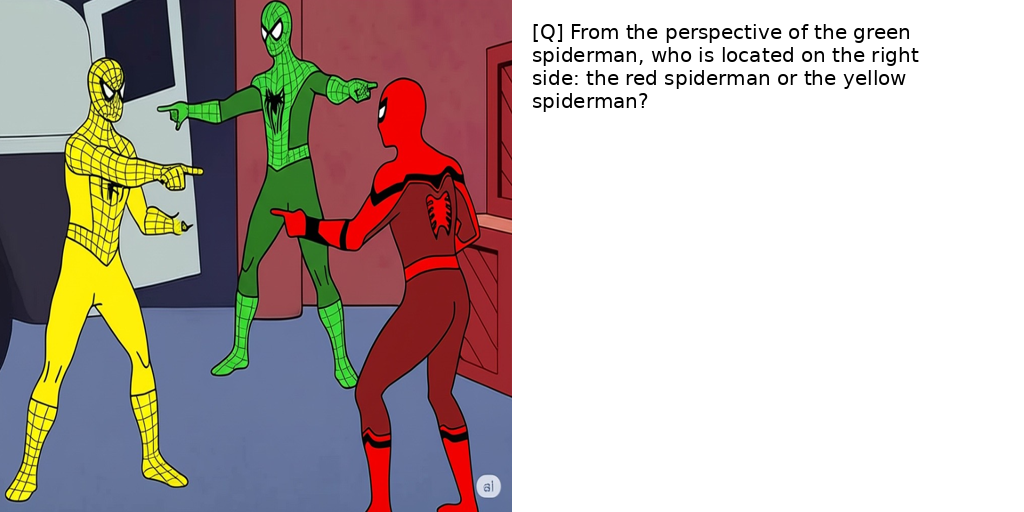

In [6]:
# load input image
image_path = "demo/sample_image_spiderman.png"
image = Image.open(image_path).convert("RGB").resize((512, 512))

# set prompt
prompt = "From the perspective of the green spiderman, who is located on the right side: the red spiderman or the yellow spiderman?"
save_dir = "outputs/demo/spiderman"

# visualize question
image_with_text = create_image_with_text(image, "[Q] " + prompt, fontsize=20)
image_with_text

### ✔️ Run APC

In [38]:
import trimesh
from trimesh.viewer import windowed
import io

def headless_render(self, resolution=(256, 256), *args, **kwargs):
    """
    Fully compatible headless fallback for trimesh.Scene.save_image().
    Returns raw PNG bytes (so downstream code expecting bytes won't break).
    """
    # Create a neutral gray placeholder image
    arr = np.ones((resolution[1], resolution[0], 3), dtype=np.uint8) * 127
    img = Image.fromarray(arr)
    
    # Encode it as PNG bytes
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    png_bytes = buf.getvalue()
    buf.close()
    return png_bytes

# Patch trimesh
trimesh.Scene.save_image = headless_render


In [39]:
# override trimesh.Scene.save_image to a safe headless version
def headless_render(self, resolution=(256, 256), *args, **kwargs):
    """
    Fallback headless renderer that just returns a blank PNG.
    It accepts all the same args/kwargs as trimesh.Scene.save_image.
    """
    arr = np.ones((resolution[1], resolution[0], 3), dtype=np.uint8) * 127  # gray image
    img = Image.fromarray(arr)
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    return buf.getvalue()

# patch trimesh
trimesh.Scene.save_image = headless_render

In [40]:
sphere = trimesh.creation.icosphere()
png = sphere.scene().save_image(resolution=(256, 256), visible=False)
print("Rendered image bytes:", len(png))

Rendered image bytes: 758


2025-10-21 22:29:38 INFO [apc.apc_pipeline] [Scene Abstraction] Objects of interest: ['green spiderman', 'red spiderman', 'yellow spiderman']
2025-10-21 22:29:38 INFO [apc.apc_pipeline] [Scene Abstraction] Running scene abstraction...
2025-10-21 22:29:38 INFO [apc.apc_pipeline] [Scene Abstraction] Running abstraction for green spiderman


[INFO] Running APC stage: do_scene_abstraction
* [INFO] Running detection for green spiderman...
* [INFO] Running detection refinement for green spiderman...
* [INFO] Response for VLM detection refinement: The image labeled as "0" is the one that best fits the description "green Spider-Man." 

So, the index of the image that best fits the description is 0.


2025-10-21 22:29:43 INFO [apc.apc_pipeline] [Scene Abstraction] Running abstraction for red spiderman


* [INFO] Running detection for red spiderman...
* [INFO] Sorting by scores in descending order
* [INFO] Running detection refinement for red spiderman...
* [INFO] Response for VLM detection refinement: The image that best fits the description "red Spider-Man" is the first one, which is labeled with the index 0.


2025-10-21 22:29:49 INFO [apc.apc_pipeline] [Scene Abstraction] Running abstraction for yellow spiderman


* [INFO] Running detection for yellow spiderman...
* [INFO] Running detection refinement for yellow spiderman...
* [INFO] Response for VLM detection refinement: The image that best fits the description "yellow Spider-Man" is the first one, which is labeled with the index 0.


2025-10-21 22:29:54 INFO [apc.apc_pipeline] [Scene Abstraction] Abstracted scene (camera's perspective): {'camera': {'position': array([0, 0, 0]), 'orientation': array([0, 0, 1])}, 'green spiderman': {'position': array([ 0.03602501, -0.14001393,  2.8725553 ], dtype=float32), 'orientation': array([-0.60181502,  0.09732919, -0.7926826 ])}, 'red spiderman': {'position': array([0.2054272, 0.0116598, 2.6968782], dtype=float32), 'orientation': array([-0.7193398 , -0.02424323,  0.6942352 ])}, 'yellow spiderman': {'position': array([-0.20842604,  0.00961616,  2.8277493 ], dtype=float32), 'orientation': array([ 0.22495105,  0.05099459, -0.97303472])}}


* [INFO] Saved the scene abstraction image to outputs/demo/spiderman/scene_abstraction.png


2025-10-21 22:29:54 INFO [apc.apc_pipeline] [Perspective Change] Reference viewer: green spiderman
2025-10-21 22:29:54 INFO [apc.apc_pipeline] [Perspective Change] Running perspective change from green spiderman...
2025-10-21 22:29:54 INFO [apc.apc_pipeline] [Perspective Change] Abstracted scene (green spiderman's perspective): {'green spiderman': {'position': array([0, 0, 0]), 'orientation': array([0, 0, 1])}, 'camera': {'position': array([-1.708, -0.085,  2.312]), 'orientation': array([ 0.605,  0.078, -0.793])}, 'red spiderman': {'position': array([-0.241,  0.147,  0.052]), 'orientation': array([ 0.993, -0.013, -0.12 ])}, 'yellow spiderman': {'position': array([0.168, 0.131, 0.197]), 'orientation': array([-0.768, -0.011,  0.641])}}
2025-10-21 22:29:54 INFO [apc.apc_pipeline] [Perspective Prompting] Generate visual perspective prompts...


[INFO] Running APC stage: do_perspective_change
[INFO] Running APC stage: do_perspective_prompting_visual
* [INFO] Scaled all positions!


2025-10-21 22:29:55 INFO [apc.apc_pipeline] [Perspective Prompting] Rendered the visual prompt!
2025-10-21 22:29:56 INFO [apc.apc_pipeline] [Perspective Prompting] Converted to egocentric: Who is located on the right side: the green cube or the yellow cube?
2025-10-21 22:29:57 INFO [apc.apc_pipeline] [Perspective Prompting] Obtained abstract response: The green cube is located on the right side.
2025-10-21 22:29:59 INFO [apc.apc_pipeline] [Perspective Prompting] Translate abstract -> real: The red spiderman is located on the right side.


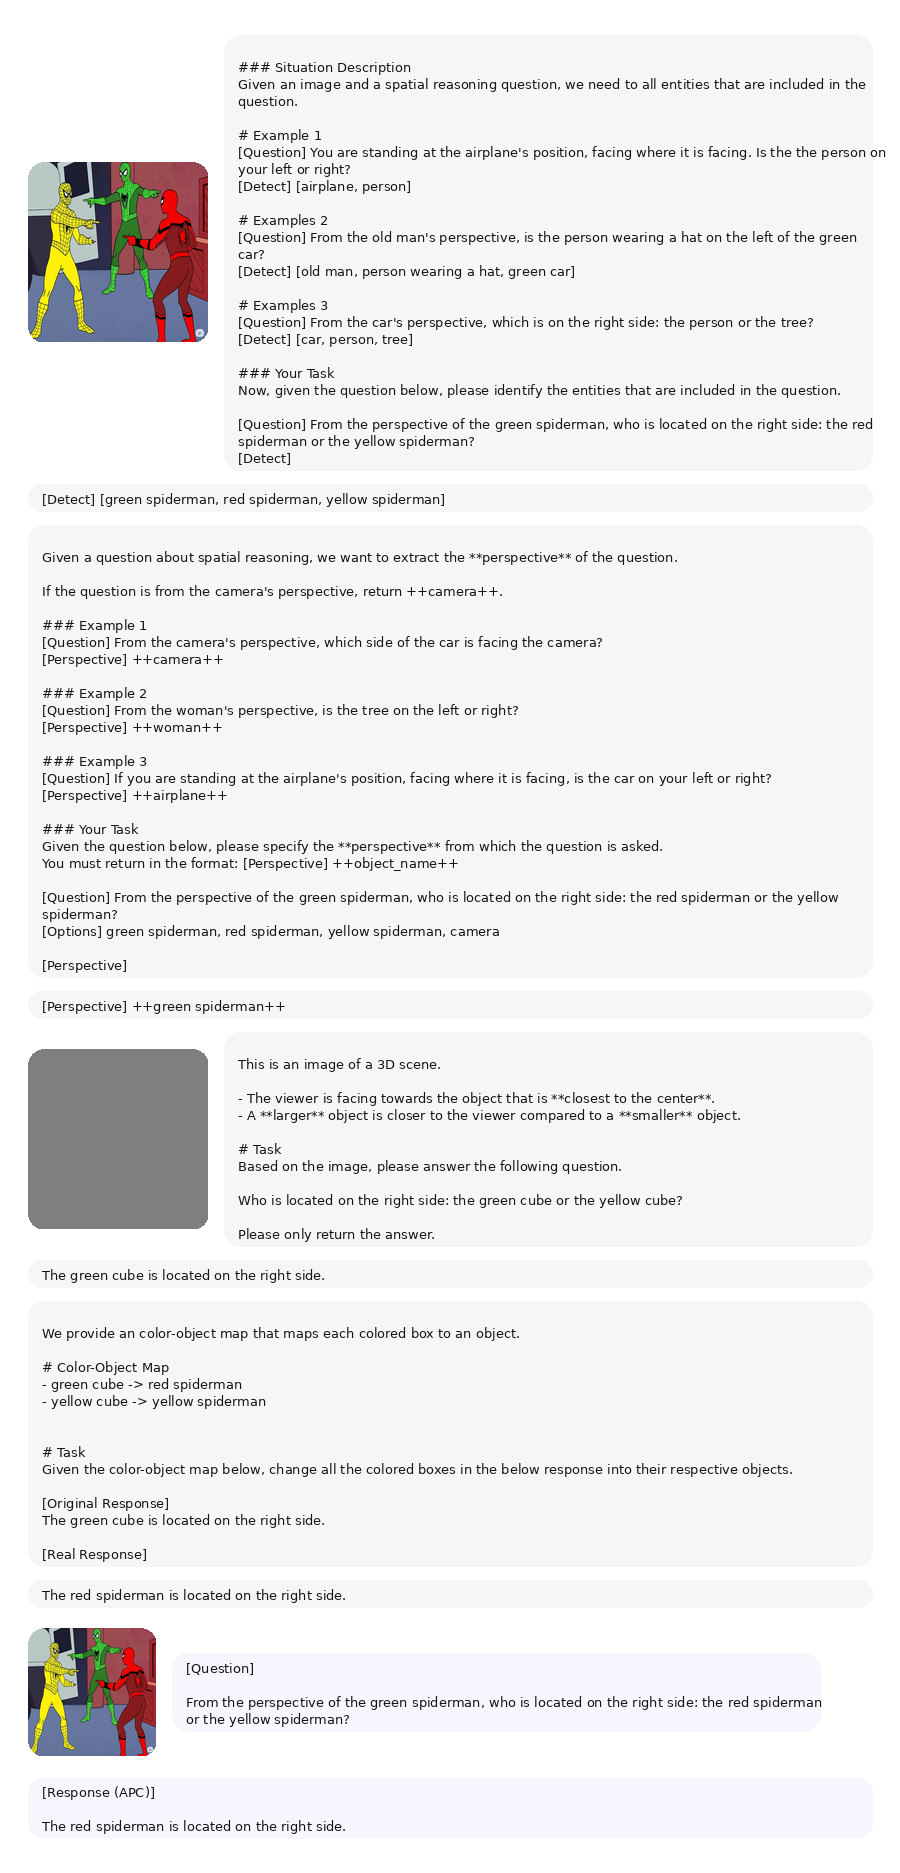

In [45]:
os.makedirs(save_dir, exist_ok=True)

# run APC
# NOTE: for faster inference, set visualize_trace=False
response, conv_history = apc.run_apc(
    image,
    prompt,
    trace_save_dir=save_dir,
    perspective_prompt_type="visual",
    visualize_trace=True,
    visualize_scene_abstraction=True,
    return_conv_history=True,
)

# visualize conversation
conv_viz = visualize_conversation(
    conv_history,
    width=900,
    row_gap=0,
    font_size=13,
    image_max_width=180,
    output_path=os.path.join(save_dir, "conversation_viz.png")
)
conv_viz

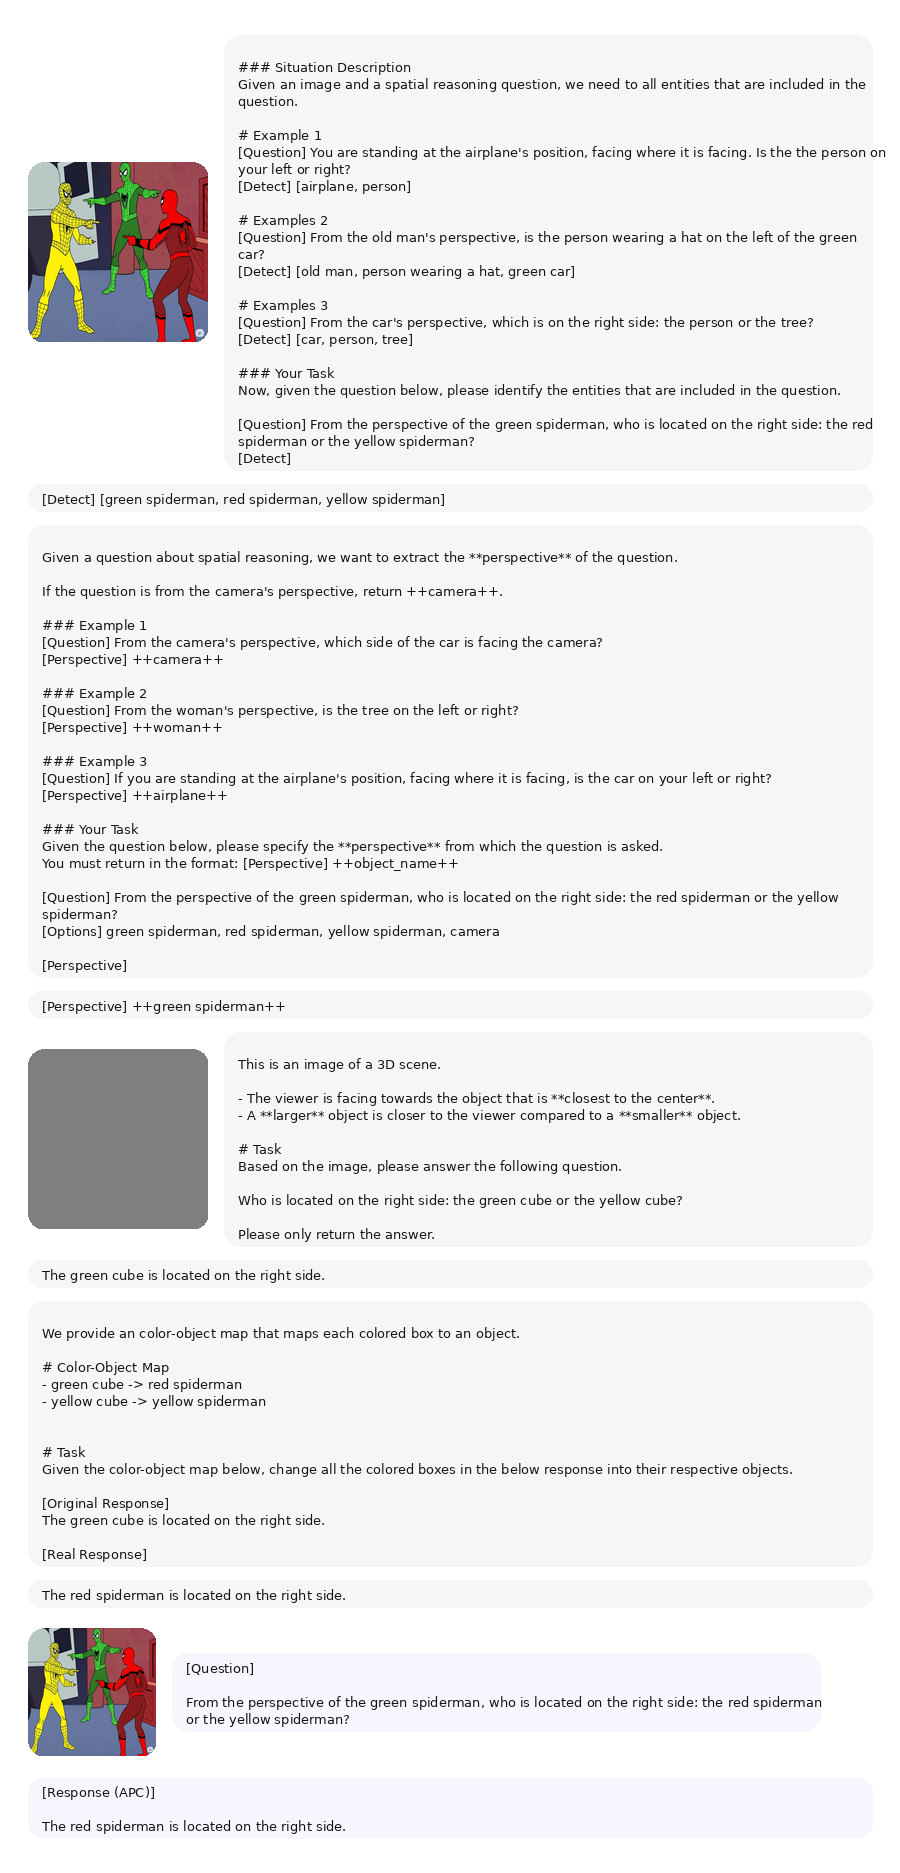

In [46]:
conv_viz

### ✔️ Run with a list of options

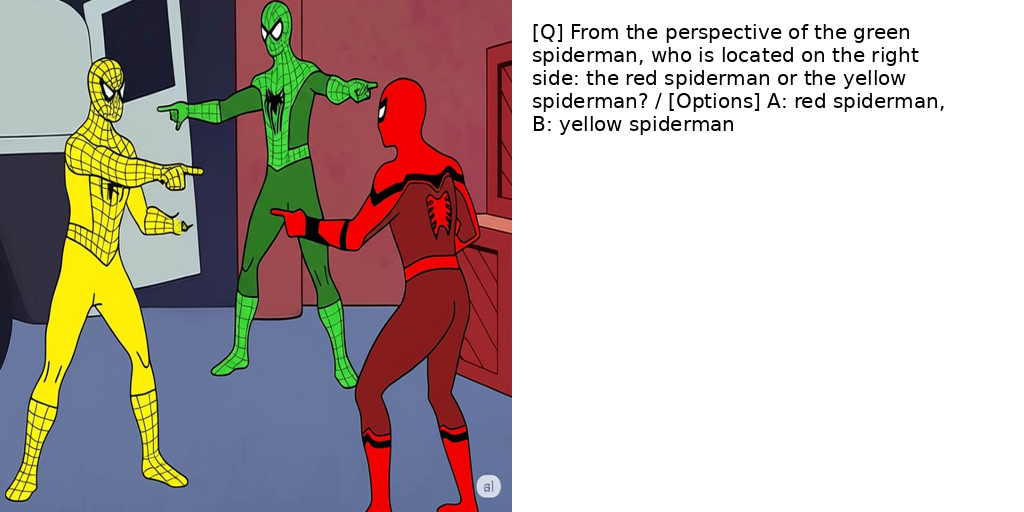

In [47]:
# load input image
image_path = "demo/sample_image_spiderman.png"
image = Image.open(image_path).convert("RGB").resize((512, 512))

# set prompt
prompt = "From the perspective of the green spiderman, who is located on the right side: the red spiderman or the yellow spiderman?"
# NOTE: add options
options = "A: red spiderman, B: yellow spiderman"
save_dir = "outputs/demo/spiderman"

# visualize question
image_with_text = create_image_with_text(image, "[Q] " + prompt + " / [Options] " + options, fontsize=20)
image_with_text

2025-10-21 22:31:27 INFO [apc.apc_pipeline] [Scene Abstraction] Objects of interest: ['green spiderman', 'red spiderman', 'yellow spiderman']
2025-10-21 22:31:27 INFO [apc.apc_pipeline] [Scene Abstraction] Running scene abstraction...
2025-10-21 22:31:27 INFO [apc.apc_pipeline] [Scene Abstraction] Running abstraction for green spiderman


[INFO] Running APC stage: do_scene_abstraction
* [INFO] Running detection for green spiderman...
* [INFO] Running detection refinement for green spiderman...
* [INFO] Response for VLM detection refinement: The image labeled as "0" is the one that best fits the description "green Spider-Man." 

So, the index of the image that best fits the description is 0.


2025-10-21 22:31:32 INFO [apc.apc_pipeline] [Scene Abstraction] Running abstraction for red spiderman


* [INFO] Running detection for red spiderman...
* [INFO] Sorting by scores in descending order
* [INFO] Running detection refinement for red spiderman...
* [INFO] Response for VLM detection refinement: The image that best fits the description "red Spider-Man" is the first one, which is labeled with the index 0.


2025-10-21 22:31:38 INFO [apc.apc_pipeline] [Scene Abstraction] Running abstraction for yellow spiderman


* [INFO] Running detection for yellow spiderman...
* [INFO] Running detection refinement for yellow spiderman...
* [INFO] Response for VLM detection refinement: The image that best fits the description "yellow Spider-Man" is the first one, which is labeled with the index 0.


2025-10-21 22:31:43 INFO [apc.apc_pipeline] [Scene Abstraction] Abstracted scene (camera's perspective): {'camera': {'position': array([0, 0, 0]), 'orientation': array([0, 0, 1])}, 'green spiderman': {'position': array([ 0.03602501, -0.14001393,  2.8725553 ], dtype=float32), 'orientation': array([-0.60181502,  0.09732919, -0.7926826 ])}, 'red spiderman': {'position': array([0.2054272, 0.0116598, 2.6968782], dtype=float32), 'orientation': array([-0.7193398 , -0.02424323,  0.6942352 ])}, 'yellow spiderman': {'position': array([-0.20842604,  0.00961616,  2.8277493 ], dtype=float32), 'orientation': array([ 0.22495105,  0.05099459, -0.97303472])}}


* [INFO] Saved the scene abstraction image to outputs/demo/spiderman/scene_abstraction.png


2025-10-21 22:31:44 INFO [apc.apc_pipeline] [Perspective Change] Reference viewer: green spiderman
2025-10-21 22:31:44 INFO [apc.apc_pipeline] [Perspective Change] Running perspective change from green spiderman...
2025-10-21 22:31:44 INFO [apc.apc_pipeline] [Perspective Change] Abstracted scene (green spiderman's perspective): {'green spiderman': {'position': array([0, 0, 0]), 'orientation': array([0, 0, 1])}, 'camera': {'position': array([-1.708, -0.085,  2.312]), 'orientation': array([ 0.605,  0.078, -0.793])}, 'red spiderman': {'position': array([-0.241,  0.147,  0.052]), 'orientation': array([ 0.993, -0.013, -0.12 ])}, 'yellow spiderman': {'position': array([0.168, 0.131, 0.197]), 'orientation': array([-0.768, -0.011,  0.641])}}
2025-10-21 22:31:44 INFO [apc.apc_pipeline] [Perspective Prompting] Generate visual perspective prompts...
2025-10-21 22:31:44 INFO [apc.apc_pipeline] [Perspective Prompting] Rendered the visual prompt!


[INFO] Running APC stage: do_perspective_change
[INFO] Running APC stage: do_perspective_prompting_visual
* [INFO] Scaled all positions!


2025-10-21 22:31:45 INFO [apc.apc_pipeline] [Perspective Prompting] Converted to egocentric: Who is located on the right side: the green cube or the yellow cube?
2025-10-21 22:31:46 INFO [apc.apc_pipeline] [Perspective Prompting] Obtained abstract response: The green cube is located on the right side.
2025-10-21 22:31:48 INFO [apc.apc_pipeline] [Perspective Prompting] Translate abstract -> real: The red spiderman is located on the right side.
2025-10-21 22:31:49 INFO [apc.apc_pipeline] [Perspective Prompting] Chose options: A: red spiderman


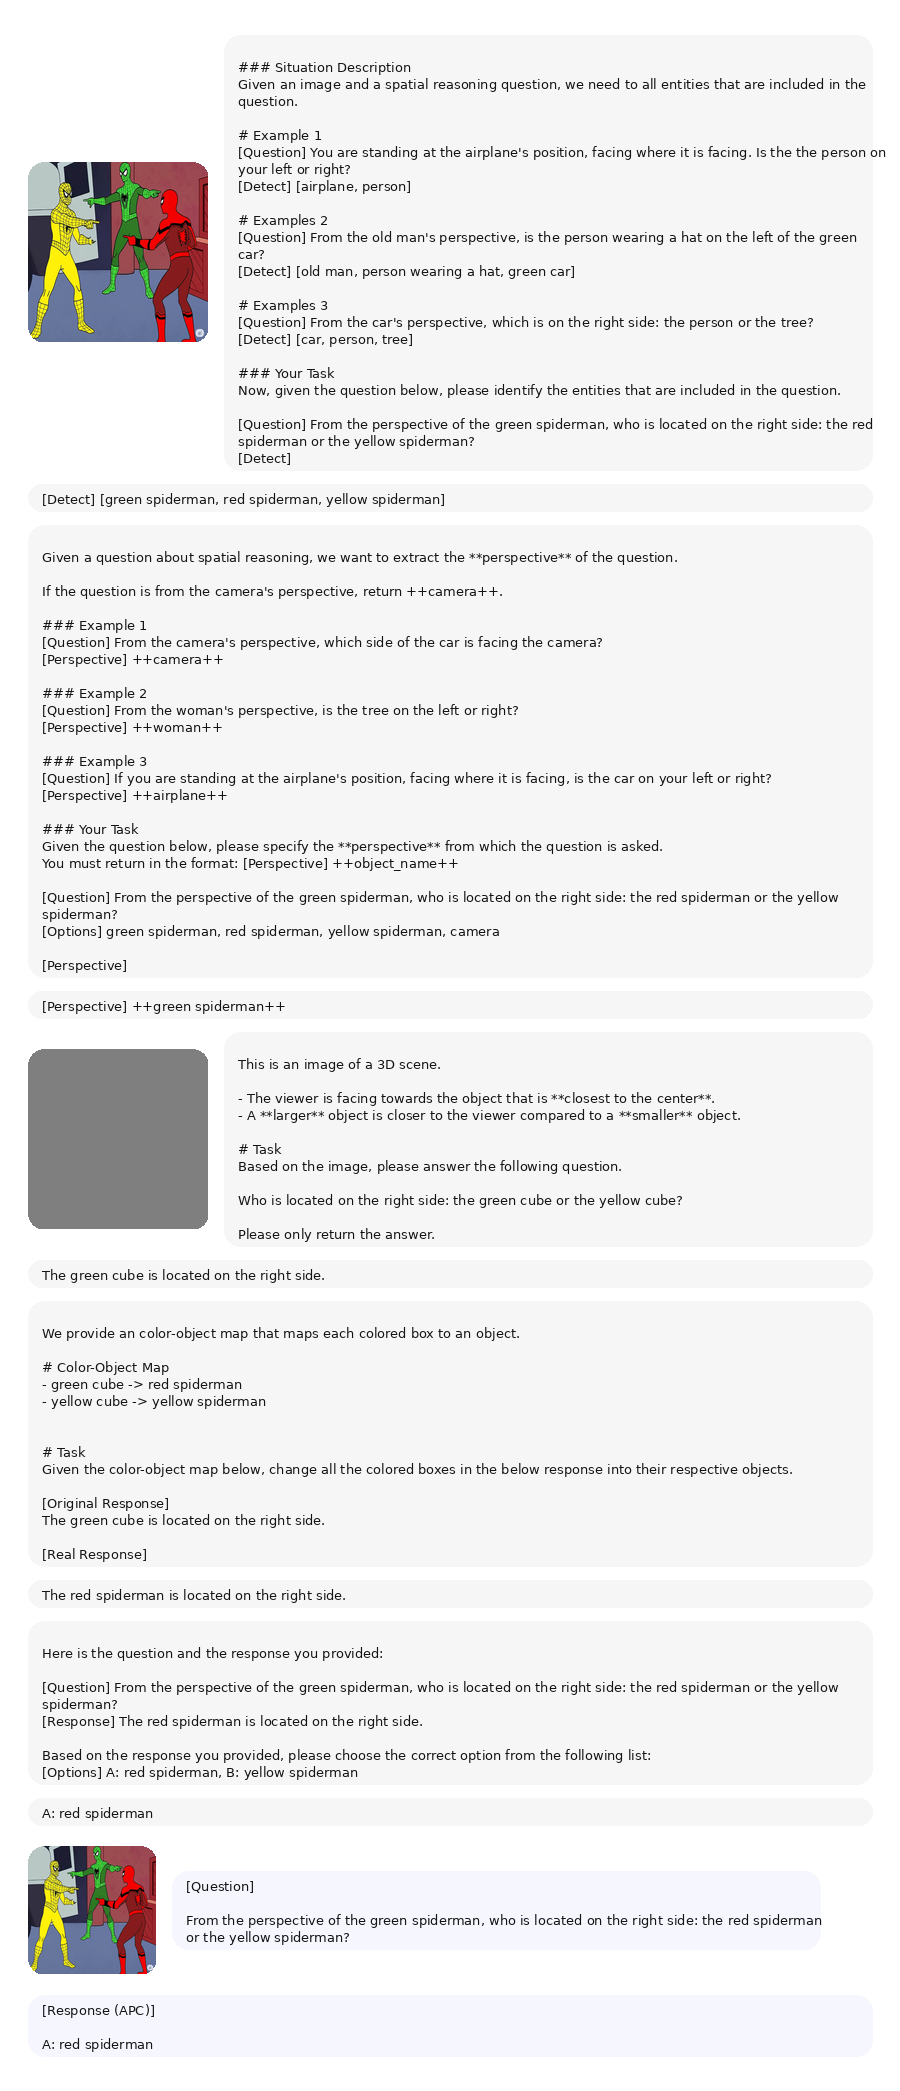

In [48]:
# set prompt
os.makedirs(save_dir, exist_ok=True)

# run APC
response, conv_history = apc.run_apc(
    image,
    prompt,
    trace_save_dir=save_dir,
    perspective_prompt_type="visual",
    visualize_trace=True,
    visualize_scene_abstraction=True,
    return_conv_history=True,
    options=options,
)

# visualize conversation
conv_viz = visualize_conversation(
    conv_history,
    width=900,
    row_gap=0,
    font_size=13,
    image_max_width=180,
    output_path=os.path.join(save_dir, "conversation_viz.png")
)
conv_viz

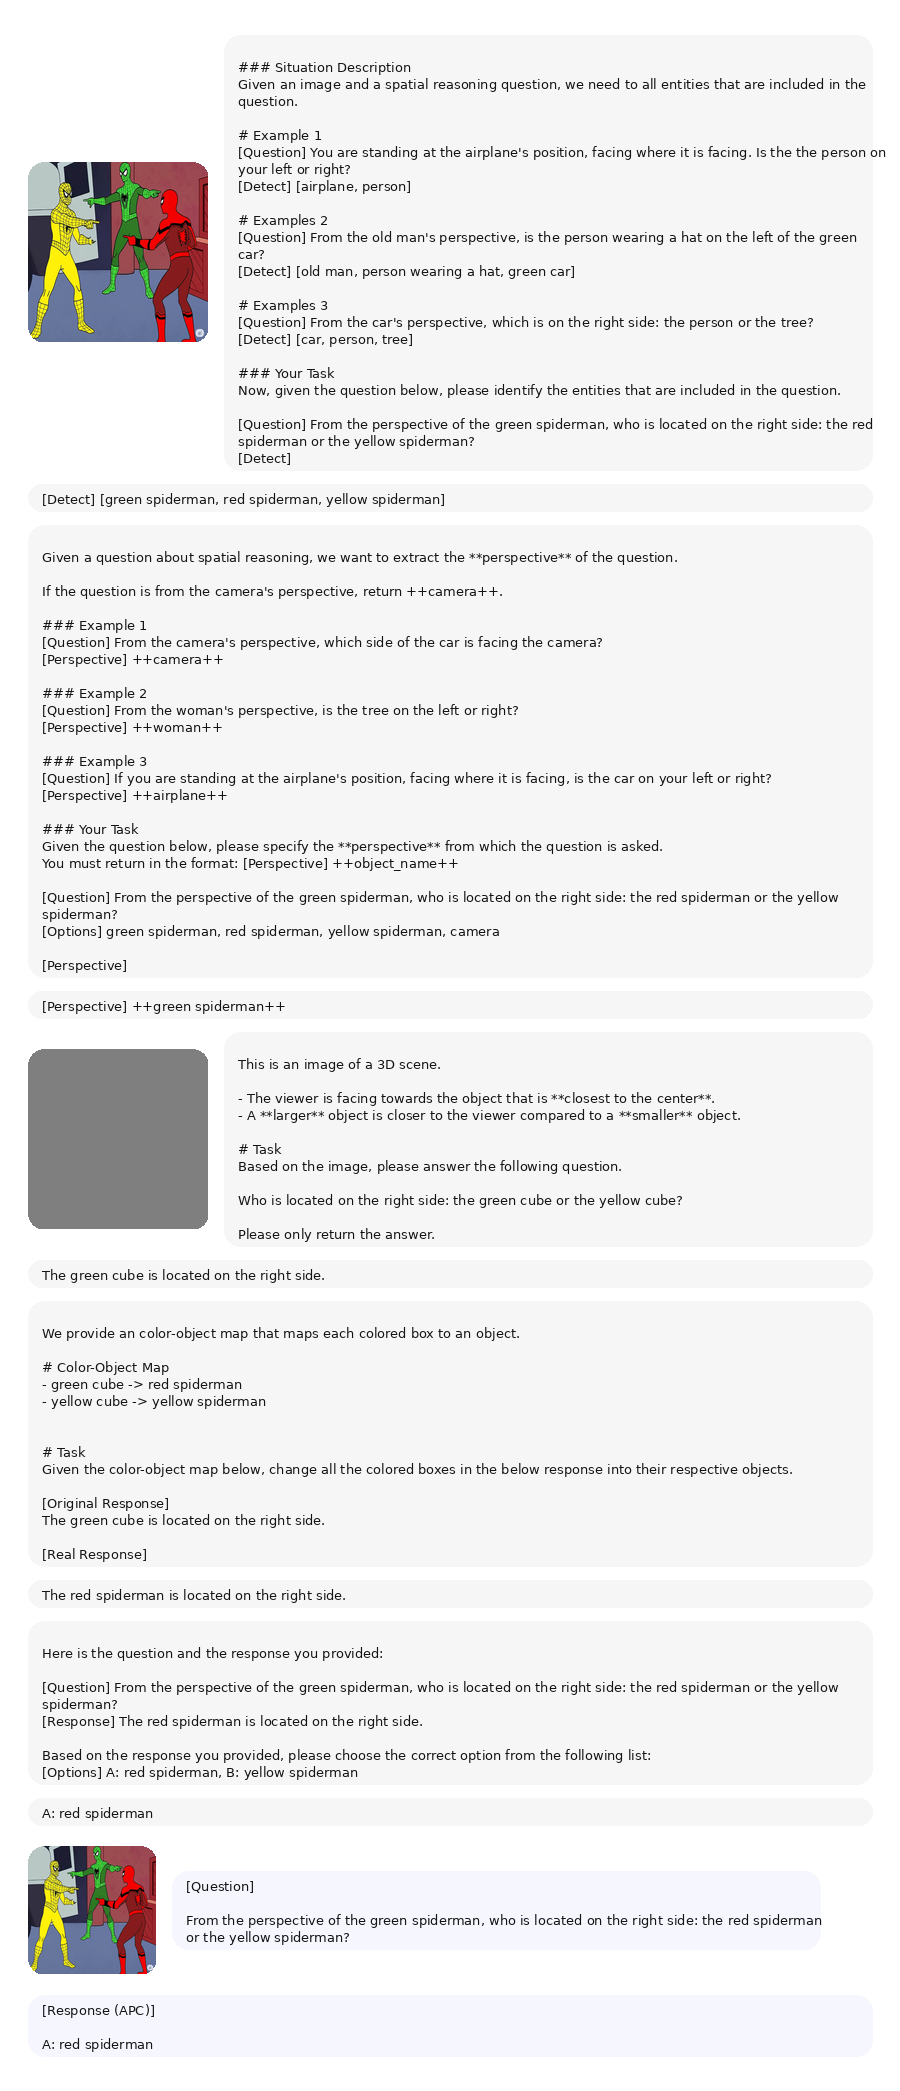

In [49]:
conv_viz

### ✔️ [Sample 2] Set input image and prompt

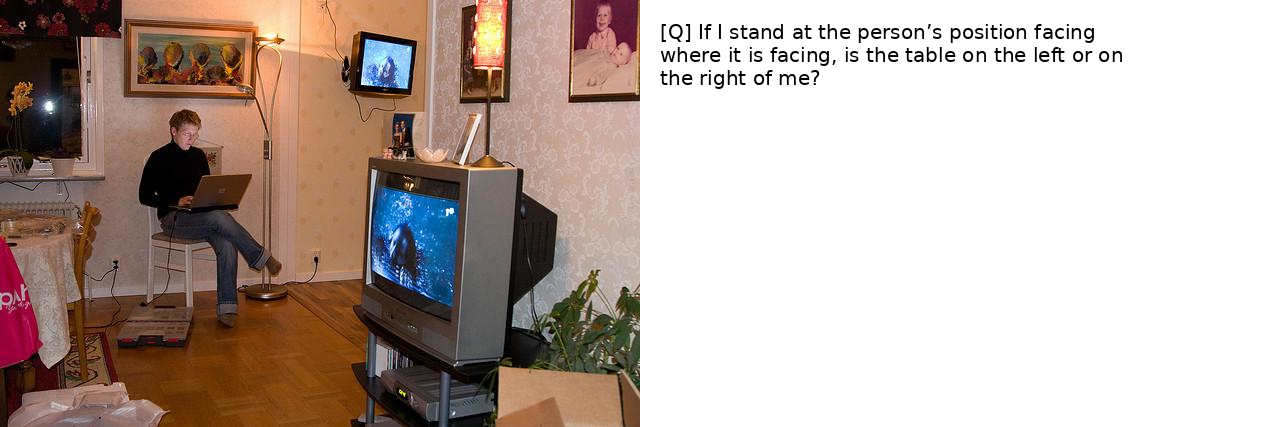

In [50]:
# load input image
image_path = "demo/sample_image_man.jpg"
image = Image.open(image_path).convert("RGB")

# set prompt
prompt = "If I stand at the person’s position facing where it is facing, is the table on the left or on the right of me?"
save_dir = "outputs/demo/man_table"

# visualize question
image_with_text = create_image_with_text(image, "[Q] " + prompt, fontsize=20)
image_with_text

2025-10-21 22:31:58 INFO [apc.apc_pipeline] [Scene Abstraction] Objects of interest: ['person', 'table']
2025-10-21 22:31:58 INFO [apc.apc_pipeline] [Scene Abstraction] Running scene abstraction...
2025-10-21 22:31:58 INFO [apc.apc_pipeline] [Scene Abstraction] Running abstraction for person


[INFO] Running APC stage: do_scene_abstraction
* [INFO] Running detection for person...
* [INFO] Sorting by scores in descending order
* [INFO] Running detection refinement for person...
* [INFO] Response for VLM detection refinement: The image that best fits the description "person" is the one labeled with the index 0. It shows a person sitting on a chair using a laptop.


2025-10-21 22:32:04 INFO [apc.apc_pipeline] [Scene Abstraction] Running abstraction for table


* [INFO] Running detection for table...
* [INFO] Sorting by scores in descending order
* [INFO] Running detection refinement for table...
* [INFO] Response for VLM detection refinement: The image that best fits the description "table" is:

- Image 0
- Image 1
- Image 3

These images show tables with items on them, such as a tablecloth and a glass.


2025-10-21 22:32:09 INFO [apc.apc_pipeline] [Scene Abstraction] Abstracted scene (camera's perspective): {'camera': {'position': array([0, 0, 0]), 'orientation': array([0, 0, 1])}, 'person': {'position': array([-0.179013  , -0.01533539,  3.8102472 ], dtype=float32), 'orientation': array([ 0.46947156,  0.10760424, -0.87636624])}, 'table': {'position': array([-0.26123846,  0.06067758,  2.43255   ], dtype=float32), 'orientation': array([-0.9945219 , -0.02351379,  0.10184941])}}


* [INFO] Saved the scene abstraction image to outputs/demo/man_table/scene_abstraction.png


2025-10-21 22:32:10 INFO [apc.apc_pipeline] [Perspective Change] Reference viewer: person
2025-10-21 22:32:10 INFO [apc.apc_pipeline] [Perspective Change] Running perspective change from person...
2025-10-21 22:32:10 INFO [apc.apc_pipeline] [Perspective Change] Abstracted scene (person's perspective): {'person': {'position': array([0, 0, 0]), 'orientation': array([0, 0, 1])}, 'camera': {'position': array([ 1.641, -0.355,  3.425]), 'orientation': array([-0.472,  0.095, -0.876])}, 'table': {'position': array([ 0.723, -0.051,  1.177]), 'orientation': array([ 0.829,  0.037, -0.559])}}
2025-10-21 22:32:10 INFO [apc.apc_pipeline] [Perspective Prompting] Generate visual perspective prompts...
2025-10-21 22:32:10 INFO [apc.apc_pipeline] [Perspective Prompting] Rendered the visual prompt!


[INFO] Running APC stage: do_perspective_change
[INFO] Running APC stage: do_perspective_prompting_visual
* [INFO] Scaled all positions!


2025-10-21 22:32:11 INFO [apc.apc_pipeline] [Perspective Prompting] Converted to egocentric: Is the green cube on the left or on the right of you?
2025-10-21 22:32:12 INFO [apc.apc_pipeline] [Perspective Prompting] Obtained abstract response: Left
2025-10-21 22:32:13 INFO [apc.apc_pipeline] [Perspective Prompting] Translate abstract -> real: Table


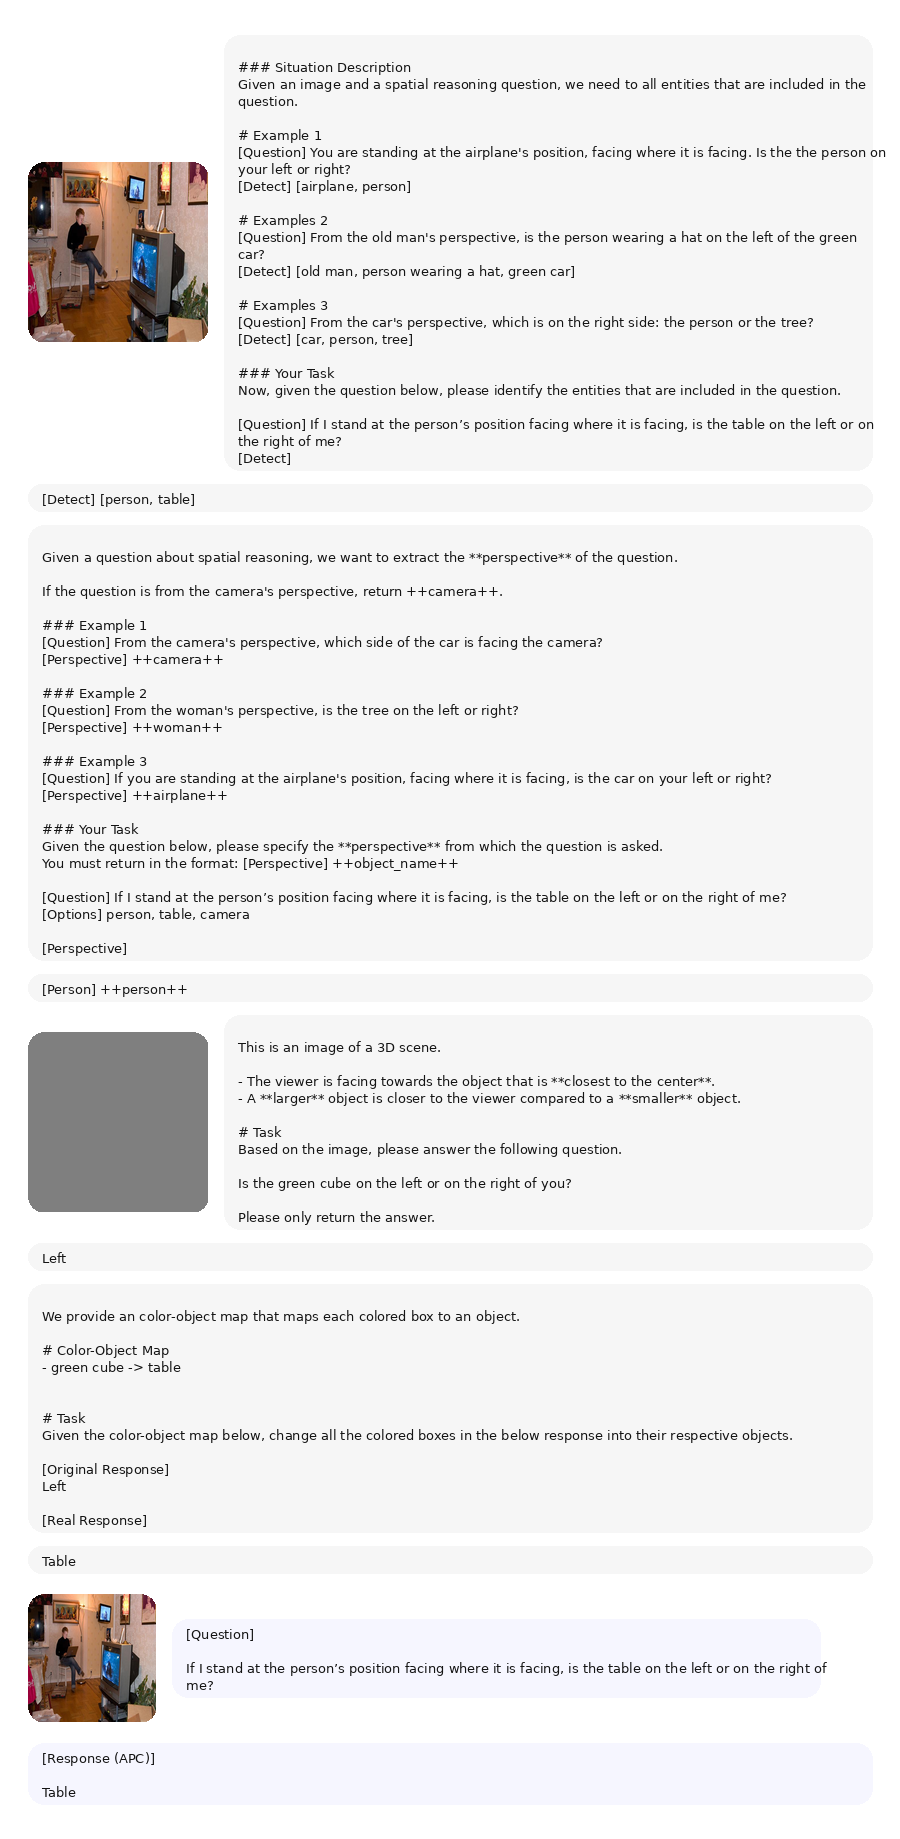

In [51]:
# set prompt
os.makedirs(save_dir, exist_ok=True)

# run APC
response, conv_history = apc.run_apc(
    image,
    prompt,
    trace_save_dir=save_dir,
    perspective_prompt_type="visual",
    visualize_trace=True,
    visualize_scene_abstraction=True,
    return_conv_history=True,
)

# visualize conversation
conv_viz = visualize_conversation(
    conv_history,
    width=900,
    row_gap=0,
    font_size=13,
    image_max_width=180,
    output_path=os.path.join(save_dir, "conversation_viz.png")
)
conv_viz

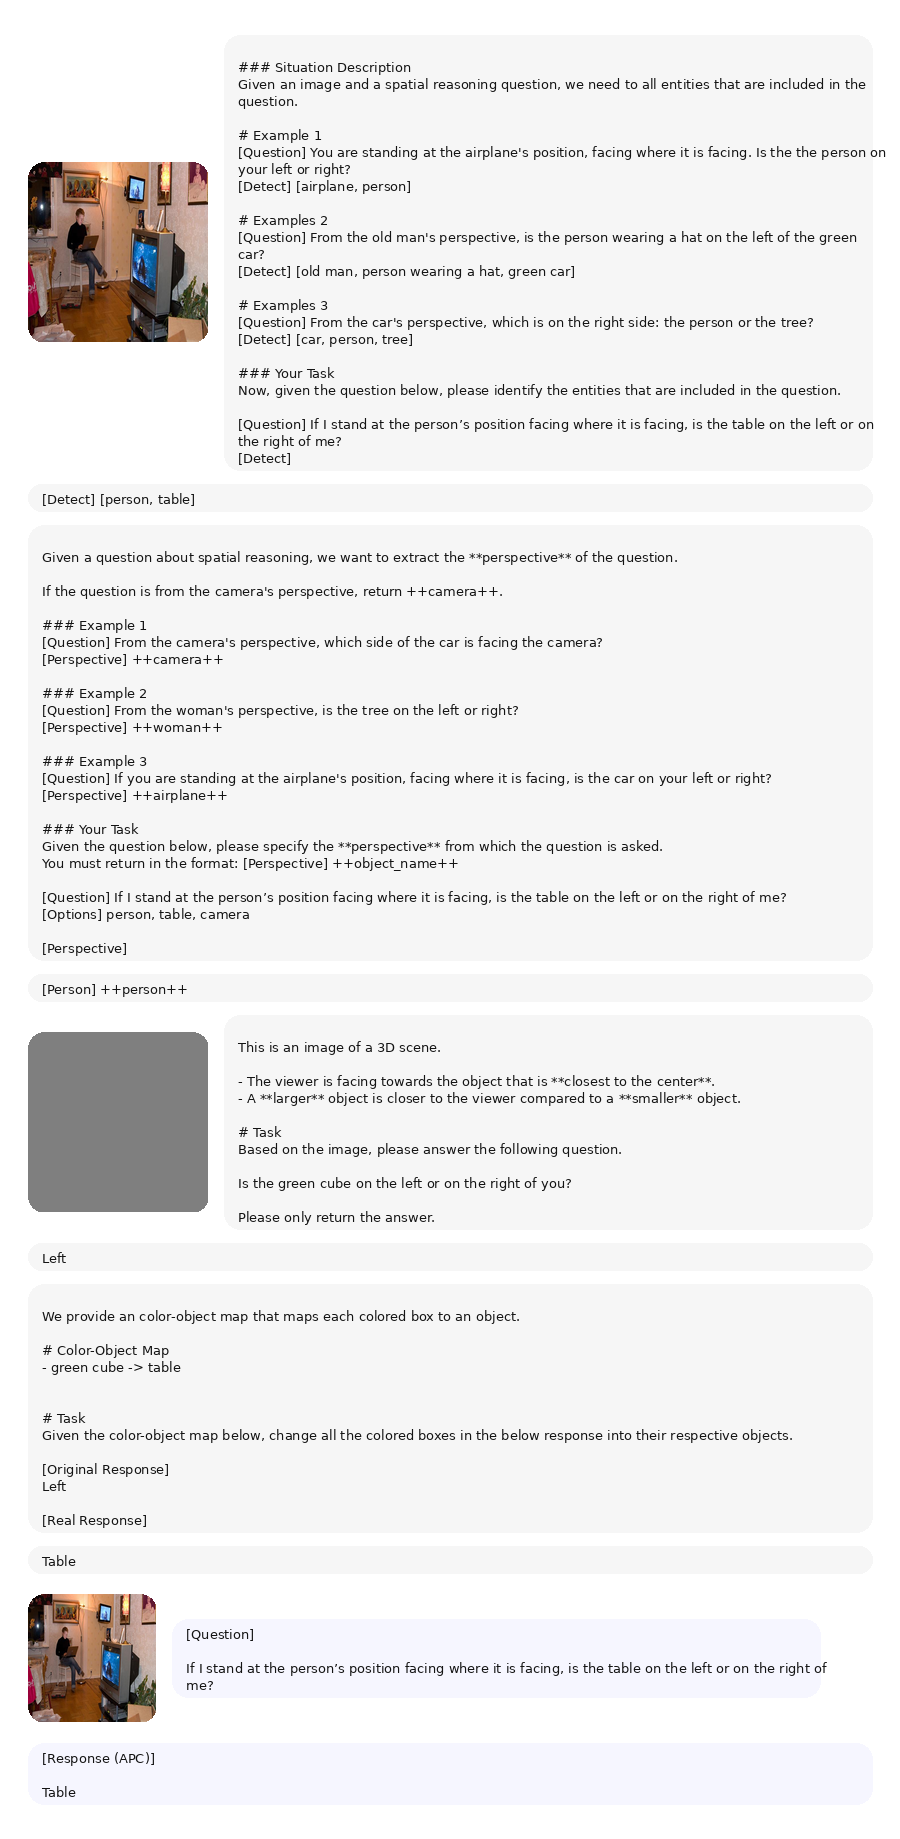

In [52]:
conv_viz

### ✔️ [Sample 3] Set input image and prompt

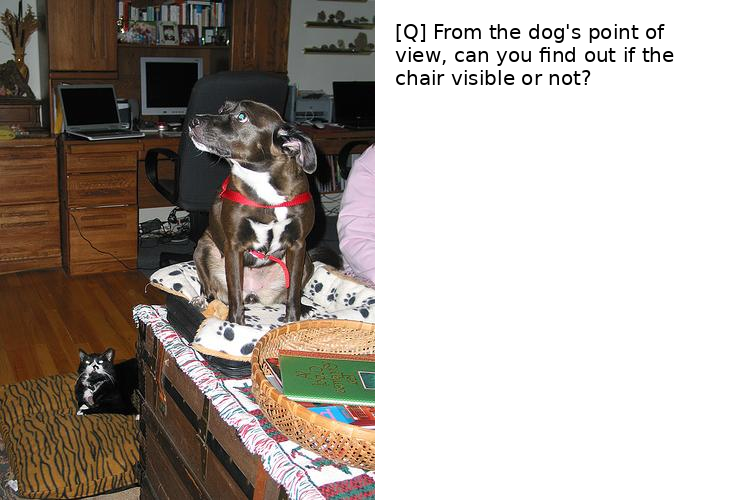

In [53]:
# load input image
image_path = "demo/sample_dog_chair.jpg"
image = Image.open(image_path).convert("RGB")

# set prompt
prompt = "From the dog's point of view, can you find out if the chair visible or not?"
save_dir = "outputs/demo/dog_chair"

# visualize question
image_with_text = create_image_with_text(image, "[Q] " + prompt, fontsize=20)
image_with_text

2025-10-21 22:32:24 INFO [apc.apc_pipeline] [Scene Abstraction] Objects of interest: ['dog', 'chair']
2025-10-21 22:32:24 INFO [apc.apc_pipeline] [Scene Abstraction] Running scene abstraction...
2025-10-21 22:32:24 INFO [apc.apc_pipeline] [Scene Abstraction] Running abstraction for dog


[INFO] Running APC stage: do_scene_abstraction
* [INFO] Running detection for dog...
* [INFO] Sorting by scores in descending order
* [INFO] Running detection refinement for dog...
* [INFO] Response for VLM detection refinement: The image that best fits the description "dog" is:

- Index 0
- Index 2
- Index 4

These images all show dogs.


2025-10-21 22:32:29 INFO [apc.apc_pipeline] [Scene Abstraction] Running abstraction for chair


* [INFO] Running detection for chair...
* [INFO] Sorting by scores in descending order
* [INFO] Running detection refinement for chair...
* [INFO] Response for VLM detection refinement: The image that best fits the description "chair" is:

- Index 0 and Index 1, as both images show a dog sitting on a chair.


2025-10-21 22:32:35 INFO [apc.apc_pipeline] [Scene Abstraction] Abstracted scene (camera's perspective): {'camera': {'position': array([0, 0, 0]), 'orientation': array([0, 0, 1])}, 'dog': {'position': array([ 0.04705779, -0.05638099,  0.98187846], dtype=float32), 'orientation': array([ 0.01745241,  0.17362173, -0.98465776])}, 'chair': {'position': array([ 0.03380219, -0.19104551,  2.7010653 ], dtype=float32), 'orientation': array([ 0.10452846,  0.08667829, -0.99073744])}}


* [INFO] Saved the scene abstraction image to outputs/demo/dog_chair/scene_abstraction.png


2025-10-21 22:32:35 INFO [apc.apc_pipeline] [Perspective Change] Reference viewer: dog
2025-10-21 22:32:35 INFO [apc.apc_pipeline] [Perspective Change] Running perspective change from dog...
2025-10-21 22:32:35 INFO [apc.apc_pipeline] [Perspective Change] Abstracted scene (dog's perspective): {'dog': {'position': array([0, 0, 0]), 'orientation': array([0, 0, 1])}, 'camera': {'position': array([ 0.064, -0.115,  0.976]), 'orientation': array([-0.018,  0.174, -0.985])}, 'chair': {'position': array([-0.017,  0.166, -1.716]), 'orientation': array([-0.087, -0.087,  0.992])}}
2025-10-21 22:32:35 INFO [apc.apc_pipeline] [Perspective Prompting] Generate visual perspective prompts...
2025-10-21 22:32:35 INFO [apc.apc_pipeline] [Perspective Prompting] Rendered the visual prompt!


[INFO] Running APC stage: do_perspective_change
[INFO] Running APC stage: do_perspective_prompting_visual


2025-10-21 22:32:36 INFO [apc.apc_pipeline] [Perspective Prompting] Converted to egocentric: Can you find out if the green cube is visible?
2025-10-21 22:32:37 INFO [apc.apc_pipeline] [Perspective Prompting] Obtained abstract response: No
2025-10-21 22:32:38 INFO [apc.apc_pipeline] [Perspective Prompting] Translate abstract -> real: No


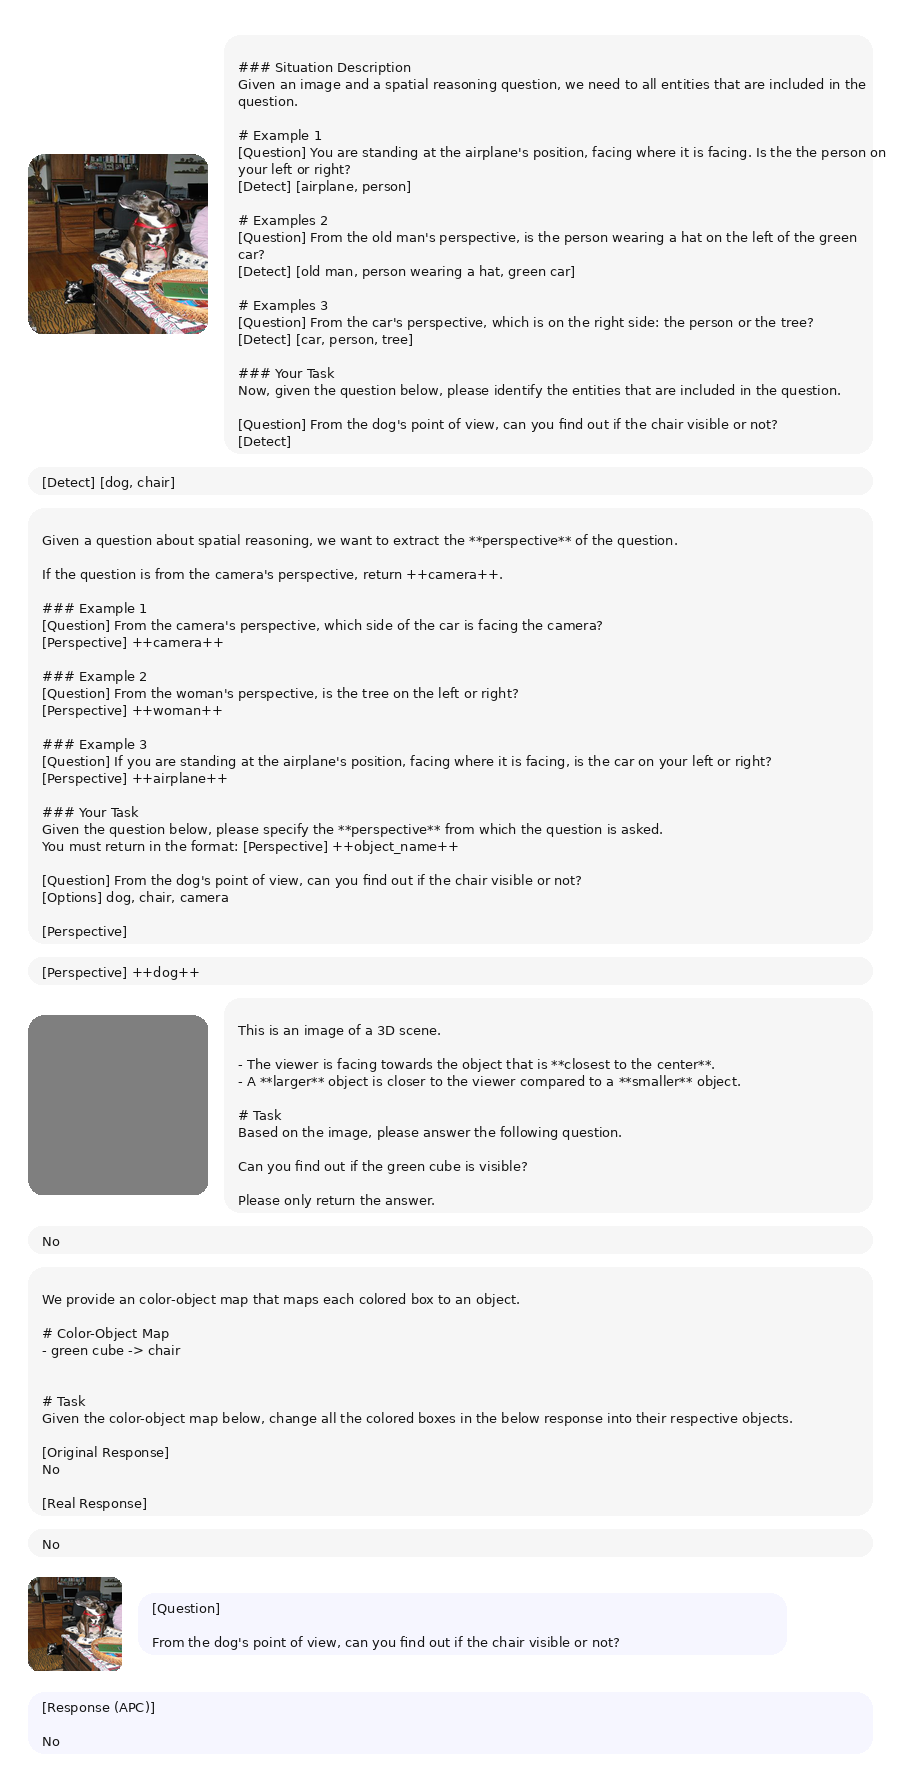

In [54]:
# set prompt
os.makedirs(save_dir, exist_ok=True)

# run APC
response, conv_history = apc.run_apc(
    image,
    prompt,
    trace_save_dir=save_dir,
    perspective_prompt_type="visual",
    visualize_trace=True,
    visualize_scene_abstraction=True,
    return_conv_history=True,
)

# visualize conversation
conv_viz = visualize_conversation(
    conv_history,
    width=900,
    row_gap=0,
    font_size=13,
    image_max_width=180,
    output_path=os.path.join(save_dir, "conversation_viz.png")
)
conv_viz

### ✔️ [Sample 4] Set input image and prompt

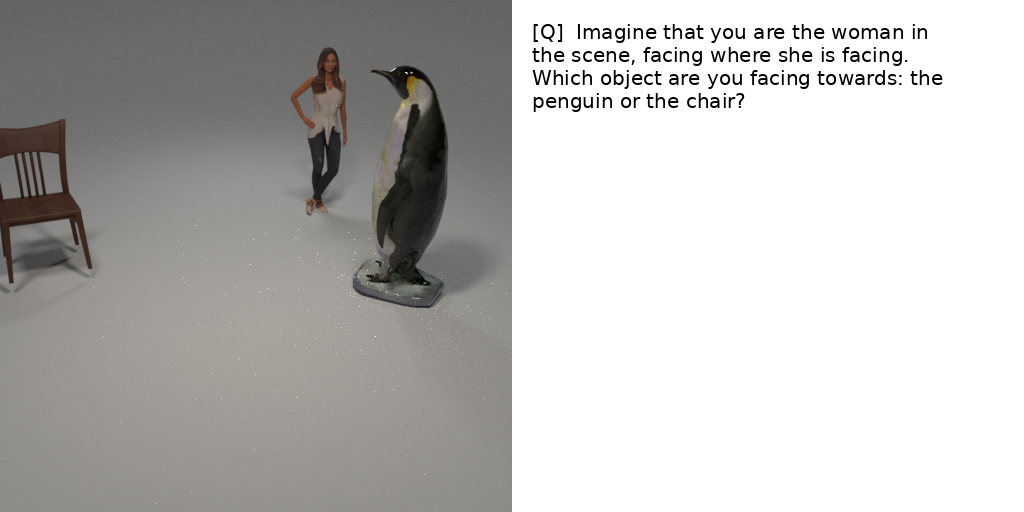

In [55]:
# load input image
image_path = "demo/sample_woman_chair.png"
image = Image.open(image_path).convert("RGB")

# set prompt
prompt = """
Imagine that you are the woman in the scene, facing where she is facing.
Which object are you facing towards: the penguin or the chair?
"""
save_dir = "outputs/demo/woman_chair"

# visualize question
image_with_text = create_image_with_text(image, "[Q] " + prompt, fontsize=20)
image_with_text

2025-10-21 22:32:46 INFO [apc.apc_pipeline] [Scene Abstraction] Objects of interest: ['woman', 'penguin', 'chair']
2025-10-21 22:32:46 INFO [apc.apc_pipeline] [Scene Abstraction] Running scene abstraction...
2025-10-21 22:32:46 INFO [apc.apc_pipeline] [Scene Abstraction] Running abstraction for woman


[INFO] Running APC stage: do_scene_abstraction
* [INFO] Running detection for woman...
* [INFO] Sorting by scores in descending order
* [INFO] Running detection refinement for woman...
* [INFO] Response for VLM detection refinement: The image labeled with the index 0 is the one that best fits the description 'woman'.


2025-10-21 22:32:50 INFO [apc.apc_pipeline] [Scene Abstraction] Running abstraction for penguin


* [INFO] Running detection for penguin...
* [INFO] Sorting by scores in descending order
* [INFO] Running detection refinement for penguin...
* [INFO] Response for VLM detection refinement: The image that best fits the description 'penguin' is the one labeled with the index 0 and 1. Both images depict penguins.

Therefore, the correct answer is either 0 or 1. Since both images are identical in this context, you can choose either one. For the sake of providing an answer, I will select the first one:

**Answer: 0**


2025-10-21 22:32:57 INFO [apc.apc_pipeline] [Scene Abstraction] Running abstraction for chair


* [INFO] Running detection for chair...
* [INFO] Running detection refinement for chair...
* [INFO] Response for VLM detection refinement: The image provided is of a chair. The index of this image is 0.


2025-10-21 22:33:00 INFO [apc.apc_pipeline] [Scene Abstraction] Abstracted scene (camera's perspective): {'camera': {'position': array([0, 0, 0]), 'orientation': array([0, 0, 1])}, 'woman': {'position': array([ 0.15244548, -0.308319  ,  4.6078916 ], dtype=float32), 'orientation': array([ 0.22495105, -0.0170051 , -0.97422166])}, 'penguin': {'position': array([ 0.24211016, -0.12444349,  3.2161205 ], dtype=float32), 'orientation': array([-0.8571673 , -0.19293666,  0.47753499])}, 'chair': {'position': array([-0.3939884 , -0.10878357,  3.6311038 ], dtype=float32), 'orientation': array([ 0.27563736,  0.43640368, -0.85649044])}}


* [INFO] Saved the scene abstraction image to outputs/demo/woman_chair/scene_abstraction.png


2025-10-21 22:33:00 INFO [apc.apc_pipeline] [Perspective Change] Reference viewer: woman
2025-10-21 22:33:00 INFO [apc.apc_pipeline] [Perspective Change] Running perspective change from woman...
2025-10-21 22:33:00 INFO [apc.apc_pipeline] [Perspective Change] Abstracted scene (woman's perspective): {'woman': {'position': array([0, 0, 0]), 'orientation': array([0, 0, 1])}, 'camera': {'position': array([1.185, 0.384, 4.45 ]), 'orientation': array([-0.225, -0.017, -0.974])}, 'penguin': {'position': array([0.226, 0.207, 1.373]), 'orientation': array([ 0.728, -0.204, -0.655])}, 'chair': {'position': array([0.752, 0.214, 0.825]), 'orientation': array([-0.076,  0.452,  0.889])}}
2025-10-21 22:33:00 INFO [apc.apc_pipeline] [Perspective Prompting] Generate visual perspective prompts...
2025-10-21 22:33:00 INFO [apc.apc_pipeline] [Perspective Prompting] Rendered the visual prompt!


[INFO] Running APC stage: do_perspective_change
[INFO] Running APC stage: do_perspective_prompting_visual
* [INFO] Scaled all positions!


2025-10-21 22:33:01 INFO [apc.apc_pipeline] [Perspective Prompting] Converted to egocentric: Which object are you facing towards: the green cube or the yellow cube?
2025-10-21 22:33:02 INFO [apc.apc_pipeline] [Perspective Prompting] Obtained abstract response: The green cube.
2025-10-21 22:33:04 INFO [apc.apc_pipeline] [Perspective Prompting] Translate abstract -> real: The penguin.


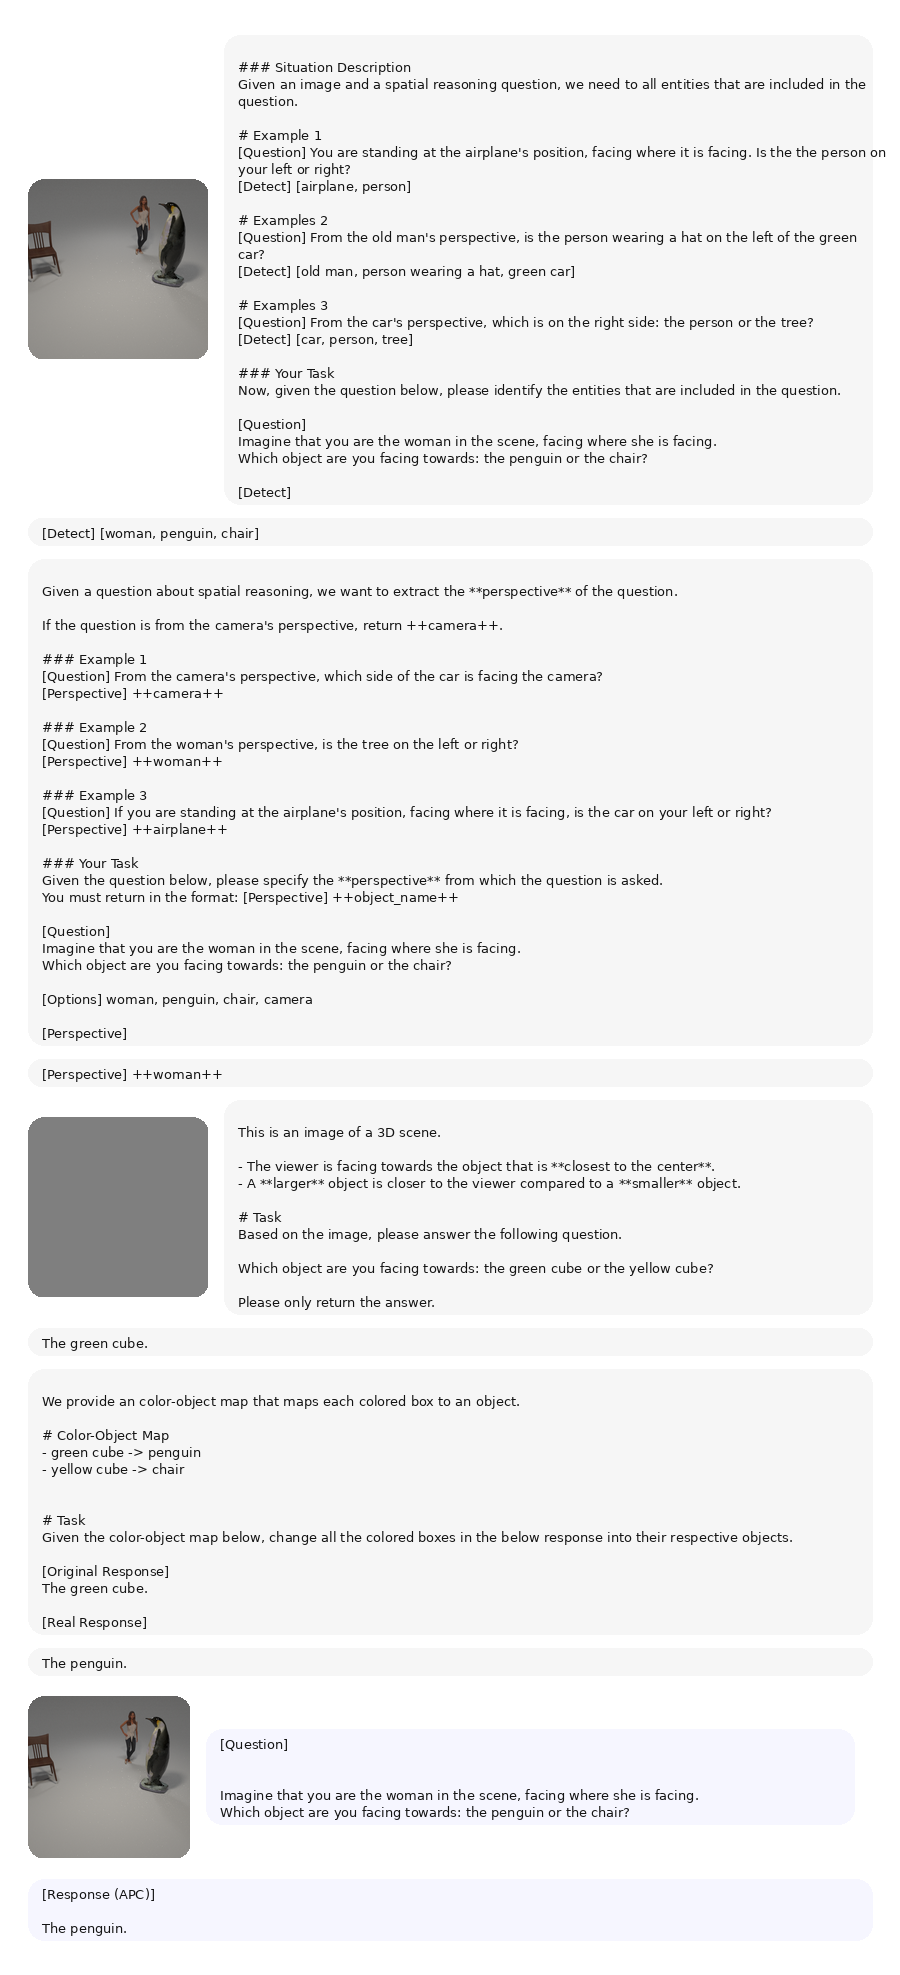

In [56]:
# set prompt
os.makedirs(save_dir, exist_ok=True)

# run APC
response, conv_history = apc.run_apc(
    image,
    prompt,
    trace_save_dir=save_dir,
    perspective_prompt_type="visual",
    visualize_trace=True,
    visualize_scene_abstraction=True,
    return_conv_history=True,
)

# visualize conversation
conv_viz = visualize_conversation(
    conv_history,
    width=900,
    row_gap=0,
    font_size=13,
    image_max_width=180,
    output_path=os.path.join(save_dir, "conversation_viz.png")
)
conv_viz

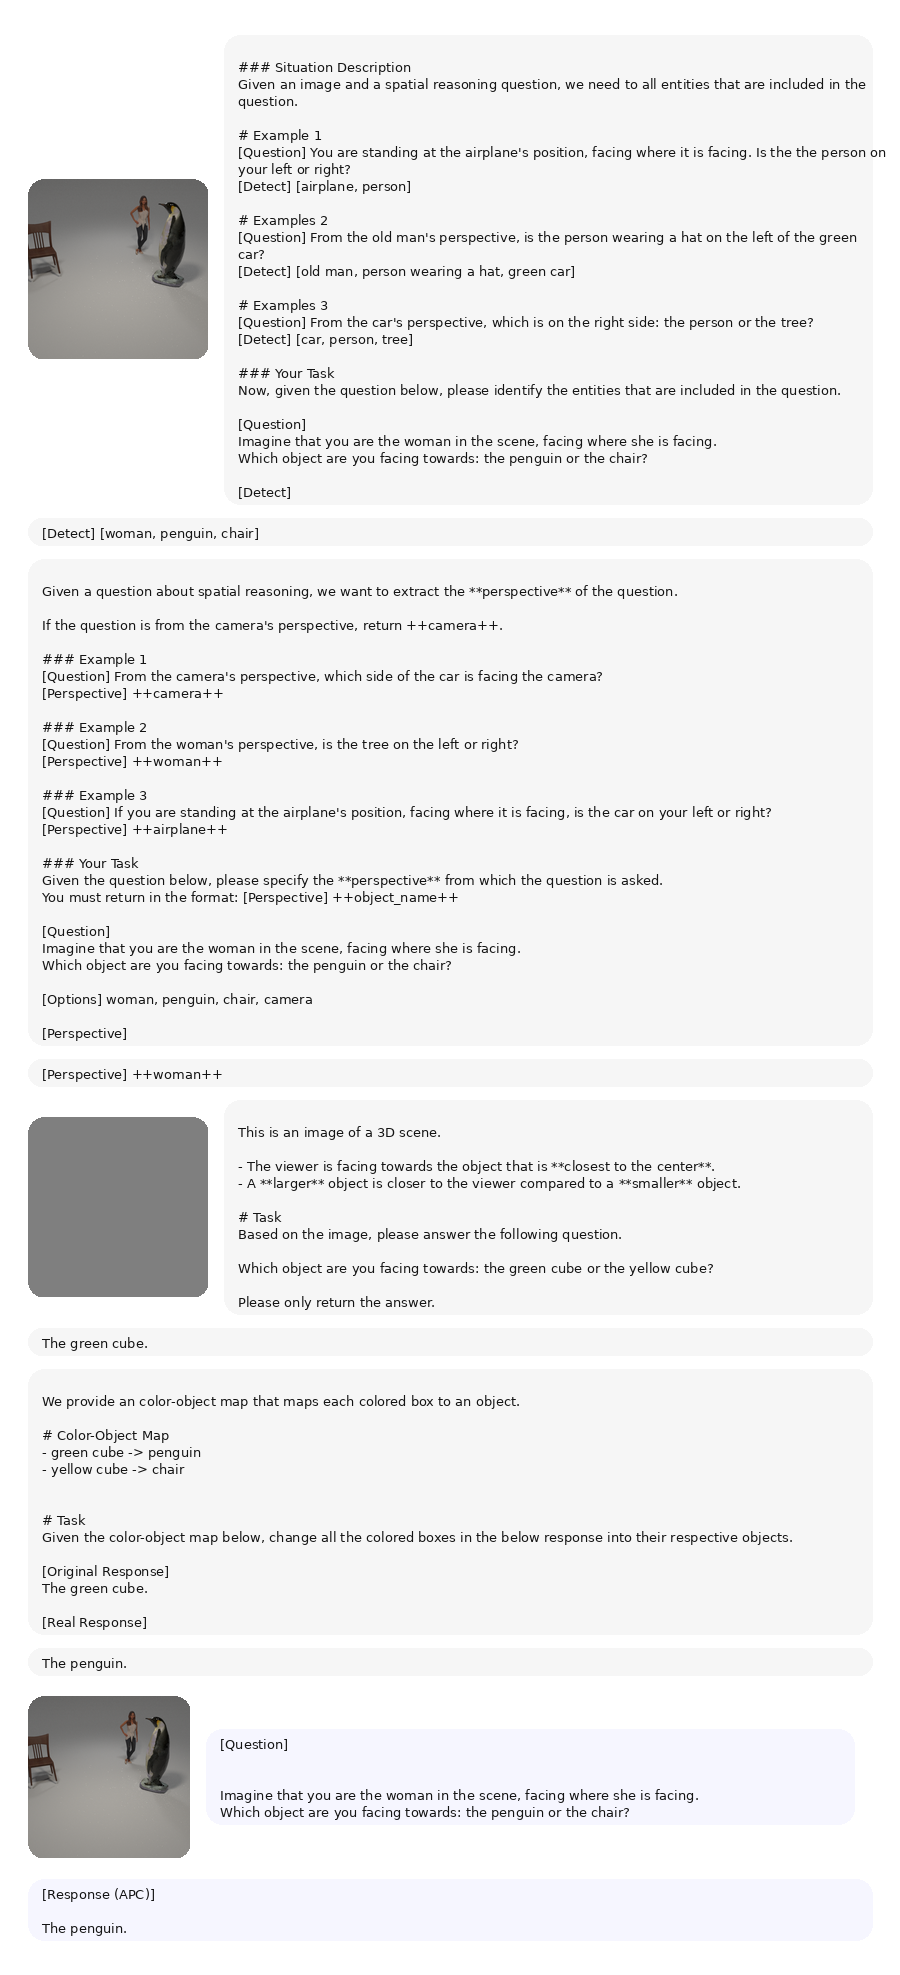

In [57]:
conv_viz